In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
file = xr.open_dataset('./olympiadData/TMP2m_daily.nc')

tmp2m = file['tmp2m']

In [49]:
## make functions for data processing

# lon 0~360 > -180~180
def sort_lon(data):
    data_ = data.assign_coords({"lon" : (((data.lon + 180) % 360) - 180)})
    data_ = data_.sortby('lon')
    return data_

# set Research month : 4~10
def Apr2Oct(data):
    data_Apr2Oct = data.sel(time=((data['time.month'] >=4) & (data['time.month']<=10)))
    return data_Apr2Oct

# slice lat/lon for each region
# and spatial average for longitude and latitude axis
def slice_region(data, lat_range, lon_range):
    sliced_tmp = data.sel(lat=(lat_range[0], lat_range[0]), lon=(lon_range[0], lon_range[1]),
                          method='nearest').mean(dim=['lon', 'lat'])
    return sliced_tmp

# Slicing the element corresponding to the condition
# including temperature convert K > Celcius
def count_proper_days(data):
    data_C = data - 273.15
    
    ri_T = data.where((data_C>=12.78) & (data_C<=17.22))    # Riesling
    ch_T = data.where((data_C>=13.89) & (data_C<=17.22))    # Chardonnay
    me_T = data.where((data_C>=16.11) & (data_C<=19.44))    # Merlot
    
    # count per year
    ri_year = ri_T.groupby("time.year").count()
    ch_year = ch_T.groupby("time.year").count()
    me_year = me_T.groupby("time.year").count()
    
    return ri_year, ch_year, me_year

    
# caculate & plot moving average
def running_mean(data, window_num):
    
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    import bottleneck as bn
    import numpy as np
    import pandas as pd
    years = data.year
    
    # caculate & plot moving average
    window_num = int(window_num)
    ma5y = bn.move_mean(data, window=window_num, min_count = None)
    
    ma5y_ = ma5y[window_num-1:]
    # print(ma5y_)
    years_ = np.array(years[window_num-1:])
    # print(years_)
    
    plt.plot(years_, ma5y_, linewidth=2, label="runnig mean")
    
    # plot trend line for moving average    
    z = np.polyfit(years_, ma5y_, 1)
    p = np.poly1d(z)
    plt.plot(years_, p(years_), "--", label="mv trend")
    
    # running mean r2
    correlation_matrix = np.corrcoef(years_, ma5y_)
    correlation_xy = correlation_matrix[0,1]
    rm_r_2 = correlation_xy**2
        
    return rm_r_2


In [4]:
# set longitude, latitude range for each region
# France Bordeaux
BRD_lat = (43.75, 45.) ; BRD_lon = (-1.25, 0.)
# France Bourgogne
BRG_lat =(46.25, 47.5) ; BRG_lon = (3.75, 5.)
# America Napa Valley
NPV_lat = (37.5, 38.75) ; NPV_lon = (-121.25, -122.5)
# Germany Rhine
RH_lat = (50., 51.25) ; RH_lon = (7.5, 8.75)

In [5]:
## data processing
resorted_lon_tmp2m = sort_lon(tmp2m)
Apr2Oct_data = Apr2Oct(resorted_lon_tmp2m)

# France Bordeaux
BRD_data = slice_region(Apr2Oct_data, BRD_lat, BRD_lon)
BRD_ri_days, BRD_ch_days, BRD_me_days = count_proper_days(BRD_data)

# France Bourgogne
BRG_data = slice_region(Apr2Oct_data, BRG_lat, BRG_lon)
BRG_ri_days, BRG_ch_days, BRG_me_days = count_proper_days(BRG_data)

# America Napa Valley
NPV_data = slice_region(Apr2Oct_data, NPV_lat, NPV_lon)
NPV_ri_days, NPV_ch_days, NPV_me_days = count_proper_days(NPV_data)

# Germany Rhine
RH_data = slice_region(Apr2Oct_data, RH_lat, RH_lon)
RH_ri_days, RH_ch_days, RH_me_days = count_proper_days(RH_data)

In [72]:
def trend(data, runningmean=bool, window_num=5):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # region name
    if 'BRD' in str(data):
        region = 'Bordeaux'
    elif 'BRG' in str(data):
        region = 'Bourgogne'
    elif 'NPV' in str(data):
        region = 'Napa Valley'
    else:
        region = 'Rhine'

    # grape type
    if 'ri' in str(data):
        grape_name = 'Riesling'
    elif 'ch' in str(data):
        grape_name = 'Chardonnay'
    else:
        grape_name = 'Merlot'

    plt.plot(data.year, data, label=region+' '+grape_name)

     
    # trend line
    z = np.polyfit(data.year, data, 1)
    p = np.poly1d(z)
    plt.plot(data.year, p(data.year), 'r--', linewidth=3, label='trend')
    
    # r2 coefficient
    correlation_matrix = np.corrcoef(data.year, data)
    correlation_xy = correlation_matrix[0,1]
    r_2 = correlation_xy**2

    plt.title('{} {} r2 = {}'.format(region, grape_name, r_2), fontweight='bold')

    if runningmean == True:
        rm_r_2 = running_mean(data, window_num)
        plt.title('{} {} r2 = {:.3f}\n running mean (window={}) = {:.3f}'.format(region, grape_name, r_2, window_num, rm_r_2),
                  fontweight='bold')
        
    plt.legend()
    plt.show()

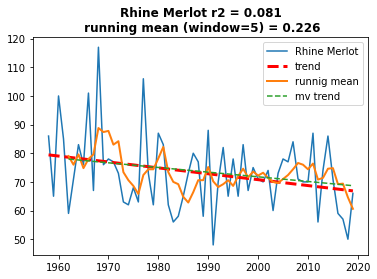

In [79]:
trend(BRG_ri_days, True)